## 2. Importing the Libraries

In [93]:
import warnings


# Disable FutureWarning related to 'multichannel' parameter
warnings.filterwarnings('ignore', category=FutureWarning)


In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tqdm import tqdm
import pywt
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
import os
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

## 3. Exploratory Data Analysis (EDA)

In [73]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [74]:
# Changing our current directory and accesing the working directory
os.chdir('/content/gdrive/MyDrive/BT')


In [75]:
# Train dataset directory
train_dir = "/content/gdrive/MyDrive/BT/Training"
# Class directories
number_classes = {'no_tumor': len(os.listdir('/content/gdrive/MyDrive/BT/Training/notumor')),
                  'glioma_tumor': len(os.listdir("/content/gdrive/MyDrive/BT/Training/glioma")),
                  'meningioma_tumor': len(os.listdir("/content/gdrive/MyDrive/BT/Training/meningioma")),
                  'pituitary_tumor': len(os.listdir("/content/gdrive/MyDrive/BT/Training/pituitary"))}

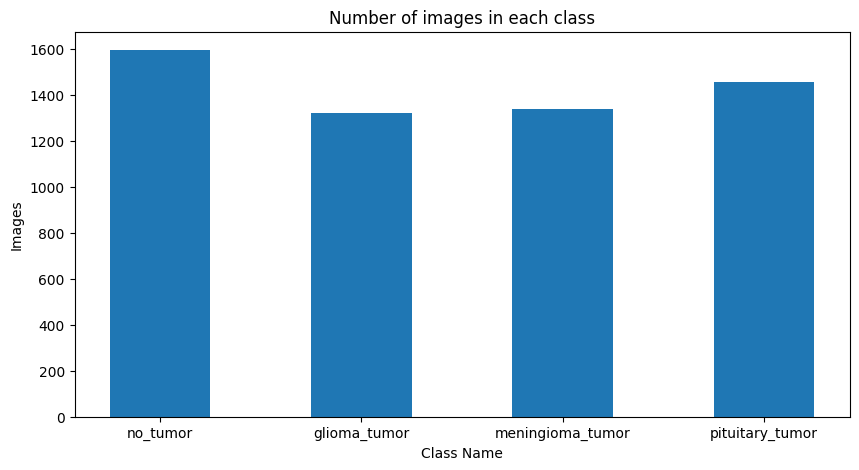

In [76]:
# Class frequency plot
fig, ax = plt.subplots(figsize=(10, 5))

plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of images in each class");
plt.xlabel('Class Name');
plt.ylabel('Images');

Gray Scale and DWT

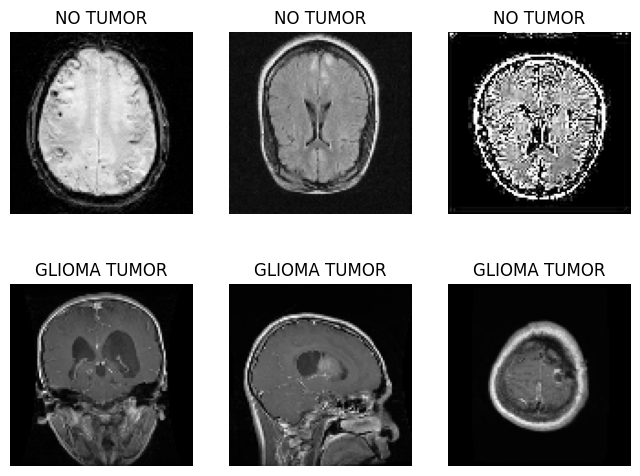

(1595, 1321)

In [80]:
train_dir = "/content/gdrive/MyDrive/BT/Training/" # image folder
# get the list of jpgs from sub image class folders
def get_images(base_dir, path, extenstion = ".jpg"):
  return [fn for fn in os.listdir(f'{base_dir}{path}') if fn.endswith(extenstion)]

no_tumor_imgs = get_images(train_dir, "notumor")
glioma_imgs = get_images(train_dir, "glioma")
meningioma_imgs = get_images(train_dir, "meningioma")
pituitary_imgs = get_images(train_dir, "pituitary")

# randomly select 3 of each
def random_select(image):
  return np.random.choice(image, 3, replace = False)

select_no_tumor = random_select(no_tumor_imgs)
select_glioma = random_select(glioma_imgs)
select_meningioma = random_select(meningioma_imgs)
select_pituitary = random_select(pituitary_imgs)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/notumor/{select_no_tumor[i]}'
        label = 'NO TUMOR'
    else:
        fp = f'{train_dir}/glioma/{select_glioma[i-3]}'
        label = 'GLIOMA TUMOR'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = load_img(fp, target_size = (100,100), color_mode='grayscale')
    coeffs = pywt.dwt2(fn, 'haar')
    pywt.idwt2(coeffs, 'haar')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
len(no_tumor_imgs), len(glioma_imgs)


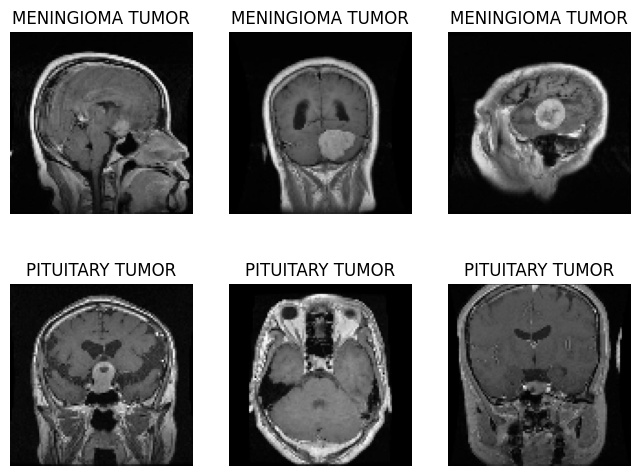

(1339, 1457)

In [83]:
# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/meningioma/{select_meningioma[i]}'
        label = 'MENINGIOMA TUMOR'
    else:
        fp = f'{train_dir}/pituitary/{select_pituitary[i-3]}'
        label = 'PITUITARY TUMOR'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = load_img(fp, target_size = (100,100), color_mode='grayscale')
    
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
len(meningioma_imgs), len(pituitary_imgs)

In [17]:
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array

Image Segmentation

In [19]:
#making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
no_tumor_images = img2np(f'{train_dir}/notumor/', no_tumor_imgs)
glioma_tumor_images = img2np(f'{train_dir}/glioma/', glioma_imgs)
meningioma_tumor_images = img2np(f'{train_dir}/meningioma/', meningioma_imgs)
pituitary_tumor_images = img2np(f'{train_dir}/pituitary/', pituitary_imgs)

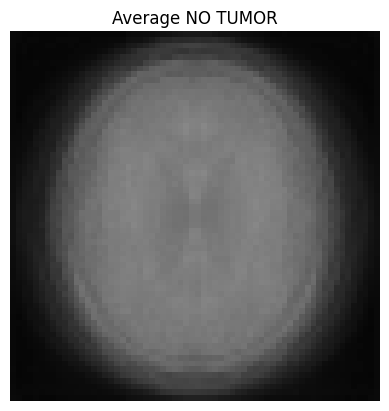

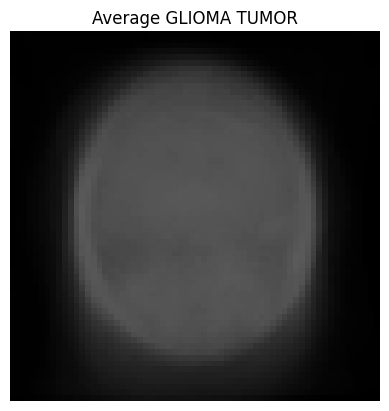

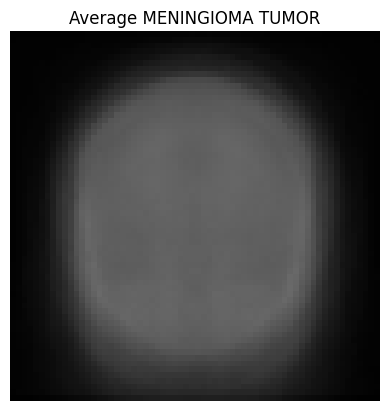

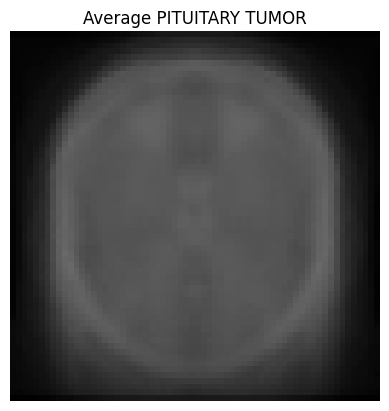

In [20]:
# we create a fucntion that does the average of each category
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    fig.tight_layout()
    plt.show()
    return mean_img

no_tumor_mean = find_mean_img(no_tumor_images, 'NO TUMOR')
glioma_mean = find_mean_img(glioma_tumor_images, 'GLIOMA TUMOR')
meningioma_mean = find_mean_img(meningioma_tumor_images, 'MENINGIOMA TUMOR')
pituitary_mean = find_mean_img(pituitary_tumor_images, 'PITUITARY TUMOR')

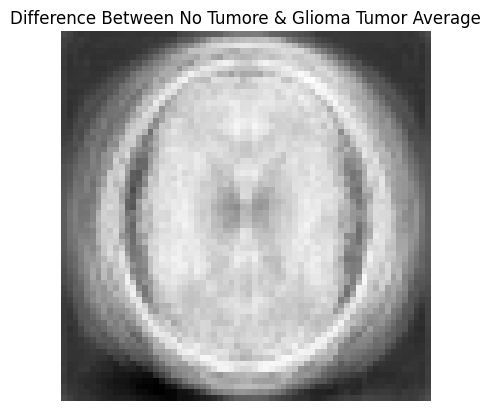

In [21]:
contrast_mean = no_tumor_mean - glioma_mean
plt.imshow(contrast_mean, cmap='Greys_r')
plt.title(f'Difference Between No Tumore & Glioma Tumor Average')
plt.axis('off')
plt.show()

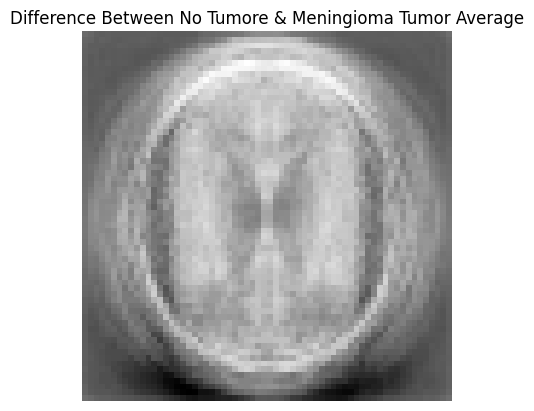

In [22]:
contrast_mean = no_tumor_mean - meningioma_mean
plt.imshow(contrast_mean, cmap='Greys_r')
plt.title(f'Difference Between No Tumore & Meningioma Tumor Average')
plt.axis('off')
plt.show()

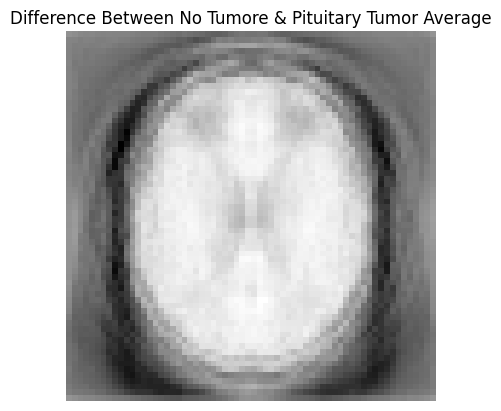

In [23]:
contrast_mean = no_tumor_mean - pituitary_mean
plt.imshow(contrast_mean, cmap='Greys_r')
plt.title(f'Difference Between No Tumore & Pituitary Tumor Average')
plt.axis('off')
plt.show()

Number of PC:  67


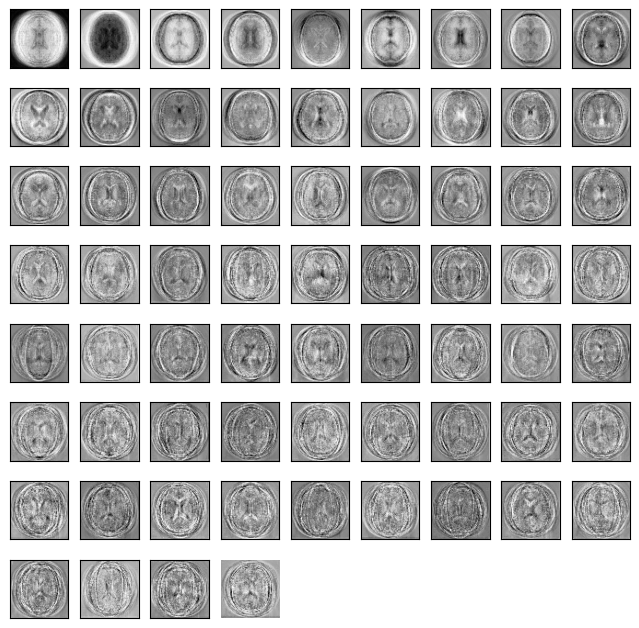

Number of PC:  94


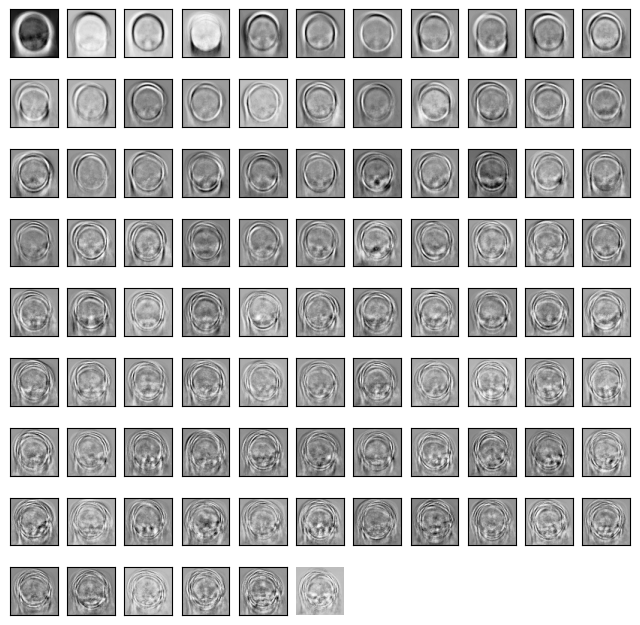

Number of PC:  81


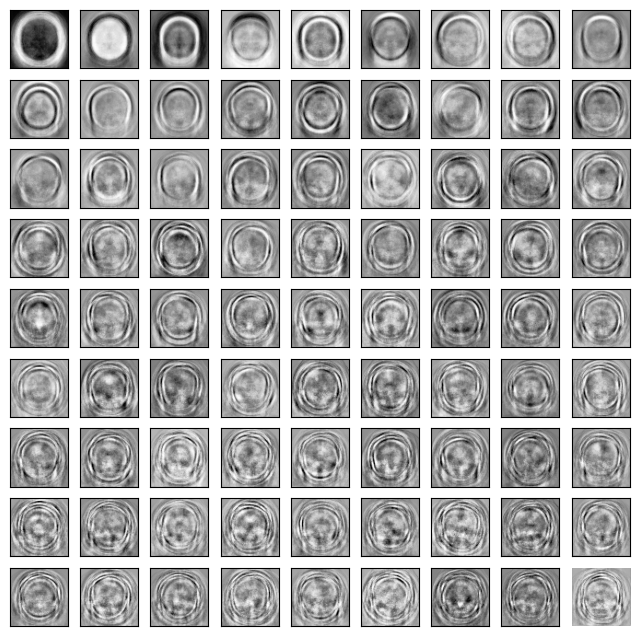

Number of PC:  103


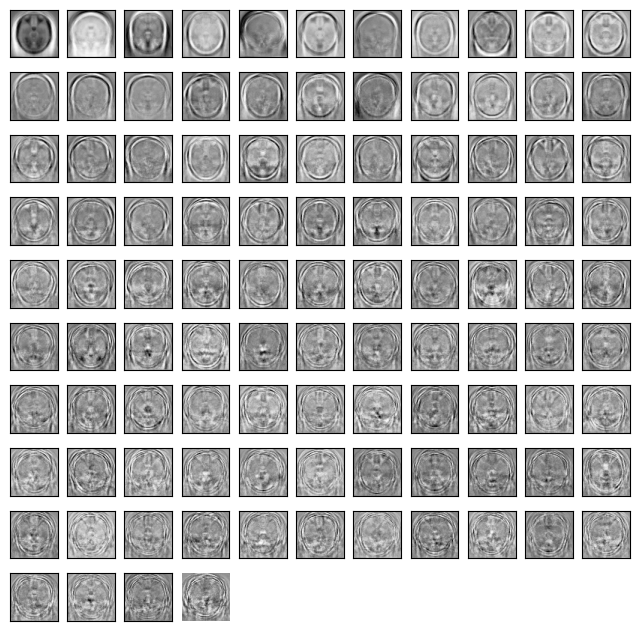

In [24]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

plot_pca(eigenimages(no_tumor_images, 'NO TUMOR'))
plot_pca(eigenimages(glioma_tumor_images, 'GLIOMA TUMOR'))
plot_pca(eigenimages(meningioma_tumor_images, 'MENINGIOMA TUMOR'))
plot_pca(eigenimages(pituitary_tumor_images, 'PITUITARY TUMOR'))

Image Augmentation (GAN)

In [ ]:
# Define the image data generator with horizontal flipping and zooming
datagen = ImageDataGenerator(horizontal_flip=True, zoom_range=0.1)

# Define the generator model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
    return model

# Define the discriminator model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define the combined generator-discriminator model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

# Define the image shape and latent dimension
img_shape = (150, 150, 3)
latent_dim = 100

# Build the generator and discriminator models
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)

# Build the GAN model
gan = build_gan(generator, discriminator)

Similarity Score

In [89]:
# Load the image datasets
dataset1_path = '/content/gdrive/MyDrive/BT/Training/glioma'
dataset2_path = '/content/gdrive/MyDrive/BT/Testing/meningioma'

In [90]:
# Load and preprocess images from the first dataset
images1 = []
for filename in os.listdir(dataset1_path):
    img = cv2.imread(os.path.join(dataset1_path, filename), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    images1.append(img)
images1 = np.array(images1)

In [92]:
# Load and preprocess images from the second dataset
images2 = []
for filename in os.listdir(dataset2_path):
    img = cv2.imread(os.path.join(dataset2_path, filename), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    images2.append(img)
images2 = np.array(images2)

In [94]:
# Calculate the similarity score using SSIM
ssim_score = 0
for i in range(306):
    ssim_score += ssim(images1[i], images2[i], multichannel=True)
ssim_score /= len(images1)
print("The SSIM score between the two image datasets is:", ssim_score)

The SSIM score between the two image datasets is: 0.078766357159831


## 5. Modeling

### Train and test sets

In [25]:
# Function used to generate the training and testing sets by combining all
# images into just a training and test set.
def train_test_1set(size, labels):
  # Train sets
  X_train, X_test, y_train, y_test = [], [], [], []
  # Folder paths
  # Training set
  for label in labels:
    folderPath = os.path.join('/content/gdrive/MyDrive/BT','Training',label)
    # Getting unique file names and using them to finish the file path
    # Display progress
    for unique in tqdm(os.listdir(folderPath)):
        # Reading images 
        image = cv2.imread(os.path.join(folderPath, unique))
        # Set image size to the defined size
        image = cv2.resize(image,(size, size))
        # Appending the image to the X train set
        X_train.append(image)
        # Appending the label for the corresponding image
        y_train.append(label)

  # Testing set     
  for label in labels:
      folderPath = os.path.join('/content/gdrive/MyDrive/BT','Testing',label)
      # Getting unique file names and using them to finish the file path
      # Display progress
      for unique in tqdm(os.listdir(folderPath)):
          # Reading the image
          image = cv2.imread(os.path.join(folderPath, unique))
          # Resizing the image according to the specified value
          image = cv2.resize(image,(size,size))
          # Appending the image to the train set
          X_train.append(image)
          # Appending the label of the correcponding image to the test set
          y_train.append(label)
          # Creating numpy arrays
  return X_train, y_train

In [26]:
# Function used to generate the training and testing sets according to the
# original divisions.
def train_test_2sets(size, labels):
  # Train sets
  X_train, X_test, y_train, y_test = [], [], [], []
  # Folder paths
  # Training set
  for label in labels:
    folderPath = os.path.join('/content/gdrive/MyDrive/BT','Training',label)
    # Getting unique file names and using them to finish the file path
    # Display progress
    for unique in tqdm(os.listdir(folderPath)):
        # Reading images 
        image = cv2.imread(os.path.join(folderPath, unique))
        # Set image size to the defined size
        image = cv2.resize(image,(size, size))
        # Appending the image to the X train set
        X_train.append(image)
        # Appending the label for the corresponding image
        y_train.append(label)

  # Testing set     
  for label in labels:
      folderPath = os.path.join('/content/gdrive/MyDrive/BT','Testing',label)
      # Getting unique file names and using them to finish the file path
      # Display progress
      for unique in tqdm(os.listdir(folderPath)):
          # Reading the image
          image = cv2.imread(os.path.join(folderPath, unique))
          # Resizing the image according to the specified value
          image = cv2.resize(image,(size,size))
          # Appending the image to the train set
          X_test.append(image)
          # Appending the label of the correcponding image to the test set
          y_test.append(label)
          # Creating numpy arrays
  return X_train, X_test, y_train, y_test

In [27]:
# Image folder labels
labels = ['glioma','meningioma','notumor','pituitary']

# Funcion call
X_train, y_train = train_test_1set(150, labels)

100%|██████████| 300/300 [00:04<00:00, 70.91it/s] 


In [28]:
# Two sets
X2_train, X2_test, y2_train, y2_test = train_test_2sets(150, labels)

100%|██████████| 300/300 [00:02<00:00, 140.17it/s]


In [29]:
# Converting to array
X_train = np.array(X_train)
y_train = np.array(y_train)
X2_train = np.array(X2_train)
X2_test = np.array(X2_test)
y2_train = np.array(y2_train)
y2_test = np.array(y2_test)
# Dataset shapes
print('Dataset shapes')
print(f'{"-"*30}\n')
print('First set:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}\n')
print('Second set:')
print(f'X_train: {X2_train.shape}')
print(f'X_test: {X2_test.shape}')
print(f'y_train: {y2_train.shape}')
print(f'y_test: {y2_test.shape}')

Dataset shapes
------------------------------

First set:
X_train: (7023, 150, 150, 3)
y_train: (7023,)

Second set:
X_train: (5712, 150, 150, 3)
X_test: (1311, 150, 150, 3)
y_train: (5712,)
y_test: (1311,)


The feature sets have 3 channels, indicating that the images are in RGB format.

### Shuffling and Label Encoding

**Shuffling**

*First set*

In [30]:
# Shuffling the training sets to randomize the order
X_train, y_train = shuffle(X_train, y_train, random_state=0)

Train-test-split

In [31]:
# Train-test-split
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state = 0)

*Second Set*

In [32]:
# Shuffling
X2_train, y2_train = shuffle(X2_train, y2_train, random_state = 0)
X2_test, y2_test = shuffle(X2_test, y2_test, random_state = 0)

**Encoding**

*Label Encoding*

In [33]:
# Label encoding
y1_train = LabelEncoder().fit_transform(y_train)
y1_test = LabelEncoder().fit_transform(y_test)
y2_train = LabelEncoder().fit_transform(y2_train)
y2_test = LabelEncoder().fit_transform(y2_test)

*One-Hot Encoding*

In [34]:
# One-Hot Encoding
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y3_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y3_test = tf.keras.utils.to_categorical(y_test)

### Convolutional Neural Networks

In [38]:
# Model evaluation line plot
def History(hist):
  fig, ax = plt.subplots(figsize = (10, 5))
  plt.plot(hist.history['accuracy'], label = 'Accuracy')
  plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc = 'upper right')
  plt.show()

In [58]:
from keras.models import Sequential
from tensorflow.keras import layers

In [59]:
# First DNN model function
def Model1(shape, labels, X_train, X_test, y_train, y_test, loss = 'sparse_categorical_crossentropy'):
  # Model definition
  model = Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation = 'relu',
            kernel_initializer = 'he_uniform', input_shape = shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # print('DNN Layer Model Summary\n')
  # print(model.summary())
  # AddinG dense layers on top
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(len(labels), activation = 'softmax'))
  # Model summary
  # print('\nMLP Layer Model Summary\n')
  # print(model.summary())
  # Model Evaluation
  # Defining the loss and optimizer
  model.compile(optimizer = 'adam', loss = loss,
              metrics = ['accuracy'])
  # Fitting the model
  history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))
  print('\nModel Evaluation\n')
  # Plotting the train and validation accuracy line graphs
  History(history)
  print()
  print()
  # Accuracy
  print('\nModel Accuracy and Loss\n')
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {test_acc}')
  print(f'TestLoss: {test_loss}')
  print()
  print()
  # Prediction
  pred = np.argmax(model.predict(X_test), axis = -1)
  # Classification report
  print('\nClassification Report\n')
  report = classification_report(y_test, pred)
  print(report)
  print()
  print()
  # Heatmap
  fig, ax = plt.subplots(figsize = (10, 8))
  sns.heatmap(confusion_matrix(y_test, pred), xticklabels=labels, yticklabels=labels,annot=True,
            cmap='viridis', fmt = 'g')
  plt.title('Heatmap', y = 1.05);

In [60]:
# Second model function
def Model2(shape, labels, X_train, X_test, y_train, y_test, loss = 'categorical_crossentropy'):
  # Model definition
  model = Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation = 'relu',
            kernel_initializer = 'he_uniform', input_shape = shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # print('DNN Layer Model Summary\n')
  # print(model.summary())
  # Adding dense layers on top
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(len(labels), activation = 'softmax'))
  # Model summary
  # print('\nMLP Layer Model Summary\n')
  # print(model.summary())
  # Model Evaluation
  # Defining the loss and optimizer
  model.compile(optimizer = 'adam', loss = loss,
              metrics = ['accuracy'])
  # Fitting the model
  history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))
  print('\nModel Evaluation\n')
  # Plotting the train and validation accuracy ine plots
  History(history)
  print()
  print()
  # Accuracy
  print('\nModel Accuracy and Loss\n')
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {test_acc}')
  print(f'TestLoss: {test_loss}')
  print()
  print()
  # Prediction
  pred = model.predict(X_test)
  pred = np.argmax(pred,axis=1)
  y_test_new = np.argmax(y_test,axis=1)
  # Classification report
  print('\nClassification Report\n')
  report = classification_report(y_test_new, pred)
  print(report)
  print()
  print()
  # Heatmap
  fig, ax = plt.subplots(figsize = (10, 8))
  sns.heatmap(confusion_matrix(y_test_new, pred), xticklabels=labels, yticklabels=labels,annot=True,
            cmap='viridis', fmt = 'g')
  plt.title('Heatmap', y = 1.05);

In [61]:
# Input features shape
shape = X_train.shape[1:]
shape

(150, 150, 3)

**First Model**

Epoch 1/10
198/198 [==============================] - 317s 2s/step - loss: 6.8132 - accuracy: 0.3144 - val_loss: 1.1802 - val_accuracy: 0.4154
Epoch 2/10
198/198 [==============================] - 312s 2s/step - loss: 1.1342 - accuracy: 0.4922 - val_loss: 0.7971 - val_accuracy: 0.6856
Epoch 3/10
198/198 [==============================] - 304s 2s/step - loss: 0.7837 - accuracy: 0.6864 - val_loss: 0.5328 - val_accuracy: 0.8151
Epoch 4/10
198/198 [==============================] - 300s 2s/step - loss: 0.6450 - accuracy: 0.7566 - val_loss: 0.4392 - val_accuracy: 0.8350
Epoch 5/10
198/198 [==============================] - 318s 2s/step - loss: 0.5367 - accuracy: 0.7984 - val_loss: 0.3914 - val_accuracy: 0.8492
Epoch 6/10
198/198 [==============================] - 305s 2s/step - loss: 0.4889 - accuracy: 0.8150 - val_loss: 0.3106 - val_accuracy: 0.8734
Epoch 7/10
198/198 [==============================] - 296s 1s/step - loss: 0.4094 - accuracy: 0.8440 - val_loss: 0.2833 - val_accuracy: 0.8876

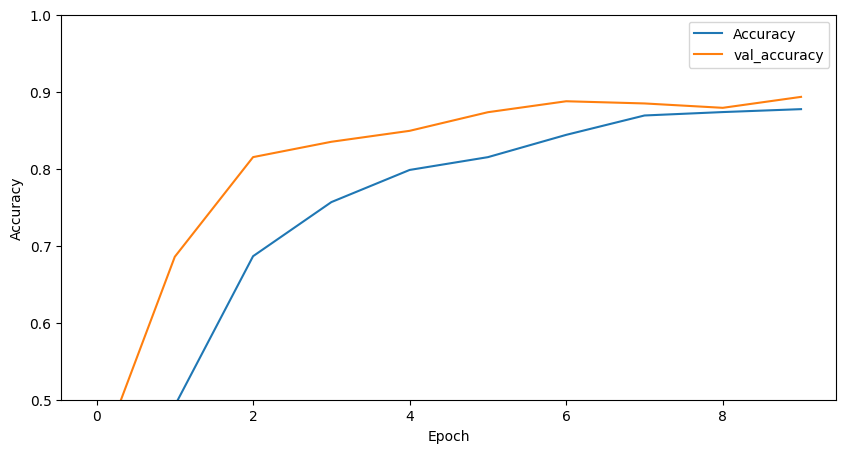




Model Accuracy and Loss

22/22 [==============================] - 9s 392ms/step - loss: 0.2886 - accuracy: 0.8933
Test Accuracy: 0.8933143615722656
TestLoss: 0.28860557079315186


22/22 [==============================] - 11s 484ms/step

Classification Report

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       163
           1       0.80      0.79      0.79       167
           2       0.92      0.98      0.95       215
           3       0.95      0.91      0.93       158

    accuracy                           0.89       703
   macro avg       0.89      0.89      0.89       703
weighted avg       0.89      0.89      0.89       703





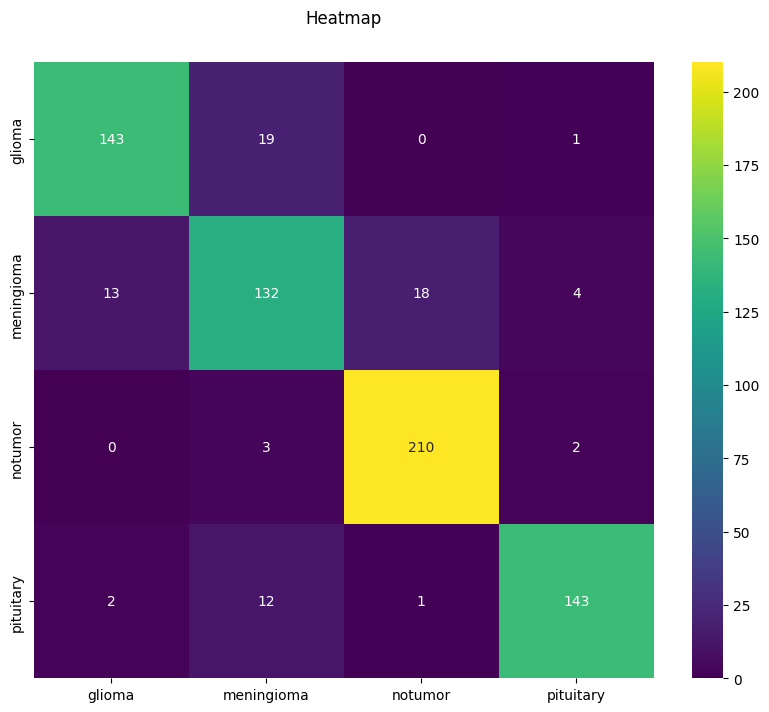

In [62]:
# 1st dataset, label encoded target
Model1(shape, labels, X_train, X_test, y1_train, y1_test)

**Second Model**

Epoch 1/10
179/179 [==============================] - 287s 2s/step - loss: 10.3861 - accuracy: 0.3356 - val_loss: 1.2221 - val_accuracy: 0.4531
Epoch 2/10
179/179 [==============================] - 293s 2s/step - loss: 1.2018 - accuracy: 0.4034 - val_loss: 1.1603 - val_accuracy: 0.4394
Epoch 3/10
179/179 [==============================] - 284s 2s/step - loss: 1.1409 - accuracy: 0.4627 - val_loss: 1.0256 - val_accuracy: 0.6301
Epoch 4/10
179/179 [==============================] - 291s 2s/step - loss: 1.0825 - accuracy: 0.5170 - val_loss: 0.9656 - val_accuracy: 0.5995
Epoch 5/10
179/179 [==============================] - 289s 2s/step - loss: 0.9939 - accuracy: 0.5653 - val_loss: 0.8434 - val_accuracy: 0.6789
Epoch 6/10
179/179 [==============================] - 286s 2s/step - loss: 0.8804 - accuracy: 0.6434 - val_loss: 0.6659 - val_accuracy: 0.7506
Epoch 7/10
179/179 [==============================] - 287s 2s/step - loss: 0.7561 - accuracy: 0.6959 - val_loss: 0.7241 - val_accuracy: 0.743

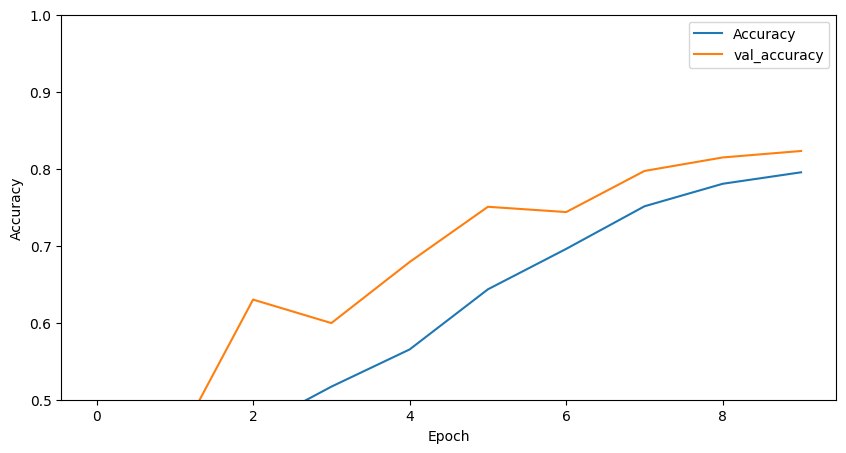




Model Accuracy and Loss

41/41 [==============================] - 17s 418ms/step - loss: 0.4377 - accuracy: 0.8230
Test Accuracy: 0.8230358362197876
TestLoss: 0.4377177357673645


41/41 [==============================] - 18s 423ms/step

Classification Report

              precision    recall  f1-score   support

           0       0.92      0.66      0.77       300
           1       0.65      0.66      0.65       306
           2       0.86      0.99      0.92       405
           3       0.87      0.93      0.90       300

    accuracy                           0.82      1311
   macro avg       0.83      0.81      0.81      1311
weighted avg       0.83      0.82      0.82      1311





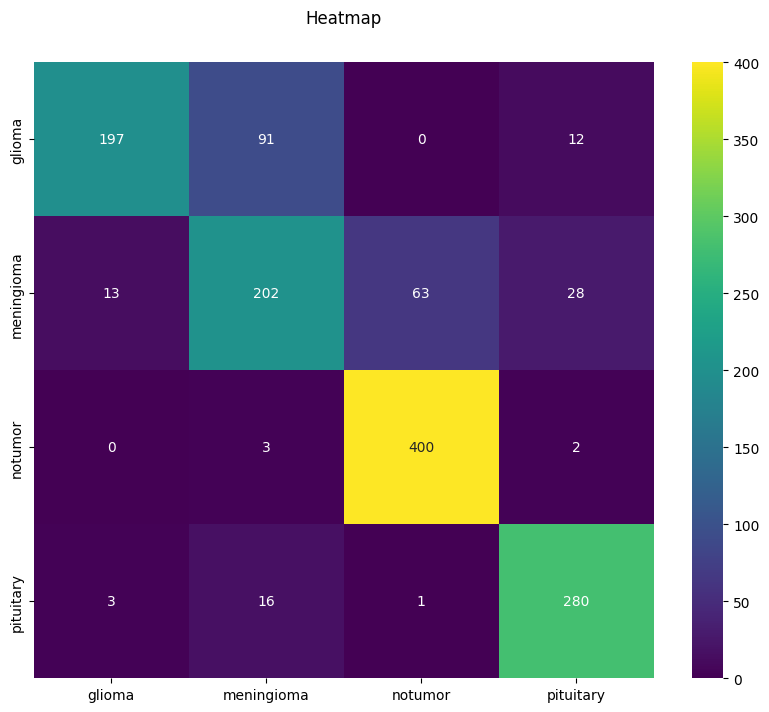

In [63]:
# 2nd dataset, label encoded target
Model1(shape, labels, X2_train, X2_test, y2_train, y2_test, loss = 'sparse_categorical_crossentropy')

**Third Model**

Epoch 1/10
92/92 [==============================] - 3s 24ms/step - loss: 19.1852 - accuracy: 0.4659 - val_loss: 0.9238 - val_accuracy: 0.5841
Epoch 2/10
92/92 [==============================] - 2s 23ms/step - loss: 0.9576 - accuracy: 0.5790 - val_loss: 0.8545 - val_accuracy: 0.6177
Epoch 3/10
92/92 [==============================] - 2s 22ms/step - loss: 0.8295 - accuracy: 0.6482 - val_loss: 0.7490 - val_accuracy: 0.6972
Epoch 4/10
92/92 [==============================] - 2s 22ms/step - loss: 0.6912 - accuracy: 0.7057 - val_loss: 0.6589 - val_accuracy: 0.7768
Epoch 5/10
92/92 [==============================] - 2s 23ms/step - loss: 0.6816 - accuracy: 0.7197 - val_loss: 0.6412 - val_accuracy: 0.7615
Epoch 6/10
92/92 [==============================] - 2s 23ms/step - loss: 0.5635 - accuracy: 0.7674 - val_loss: 0.5992 - val_accuracy: 0.7920
Epoch 7/10
92/92 [==============================] - 2s 22ms/step - loss: 0.5303 - accuracy: 0.7861 - val_loss: 0.5987 - val_accuracy: 0.8135
Epoch 8/10
9

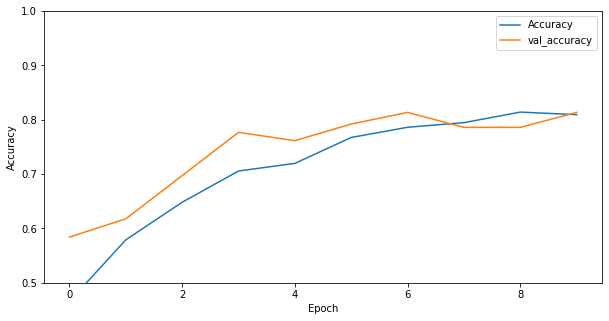




Model Accuracy and Loss

11/11 [==============================] - 0s 10ms/step - loss: 0.6625 - accuracy: 0.8135
Test Accuracy: 0.8134556412696838
TestLoss: 0.6625462770462036



Classification Report

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       110
           1       0.71      0.73      0.72        82
           2       0.70      0.90      0.79        48
           3       0.92      0.97      0.94        87

    accuracy                           0.81       327
   macro avg       0.80      0.83      0.81       327
weighted avg       0.82      0.81      0.81       327





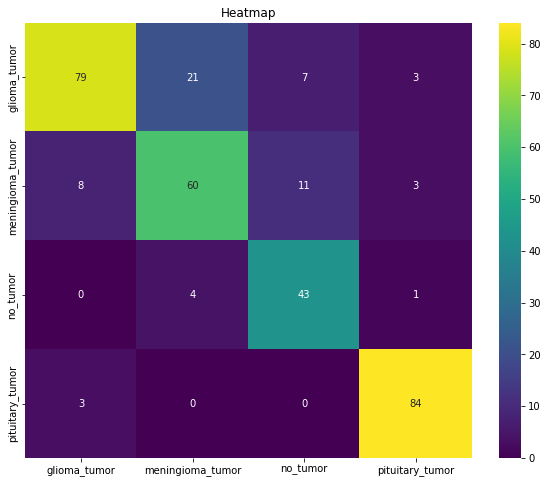

In [ ]:
# 1st dataset, one hot encoded target
Model2(shape, labels, X_train, X_test, y3_train, y3_test, loss = 'categorical_crossentropy')

**Fourth Model**

In [66]:
# DNN function for the second model
def Model3(shape, labels, X_train, X_test, y_train, y_test, loss = 'categorical_crossentropy'):
  # Model definition
  model = Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape= shape))
  model.add(layers.MaxPool2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(len(labels), activation='softmax'))
  # Defining the loss and optimizer
  model.compile(optimizer='adam', loss= loss, metrics=['accuracy'])
  # Fitting the model
  history = model.fit(X_train, y_train, epochs=10, batch_size=128)
  # Accuracy
  print('\nModel Accuracy and Loss\n')
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {test_acc}')
  print(f'TestLoss: {test_loss}')
  print()
  print()
  # Prediction
  pred = model.predict(X_test)
  pred = np.argmax(pred,axis=1)
  y_test_new = np.argmax(y_test,axis=1)
  # Classification report
  print('\nClassification Report\n')
  report = classification_report(y_test_new, pred)
  print(report)
  print()
  print()
  # Heatmap
  fig, ax = plt.subplots(figsize = (10, 8))
  sns.heatmap(confusion_matrix(y_test_new, pred), xticklabels=labels, yticklabels=labels,annot=True,
            cmap='viridis', fmt = 'g')
  plt.title('Heatmap', y = 1.05);
  


Epoch 1/10
50/50 [==============================] - 156s 3s/step - loss: 634.7097 - accuracy: 0.2641
Epoch 2/10
50/50 [==============================] - 141s 3s/step - loss: 1.3791 - accuracy: 0.2824
Epoch 3/10
50/50 [==============================] - 145s 3s/step - loss: 1.3782 - accuracy: 0.2824
Epoch 4/10
50/50 [==============================] - 140s 3s/step - loss: 1.3778 - accuracy: 0.2824
Epoch 5/10
50/50 [==============================] - 146s 3s/step - loss: 1.3778 - accuracy: 0.2824
Epoch 6/10
50/50 [==============================] - 143s 3s/step - loss: 1.3767 - accuracy: 0.2824
Epoch 7/10
50/50 [==============================] - 148s 3s/step - loss: 1.3776 - accuracy: 0.2824
Epoch 8/10
50/50 [==============================] - 143s 3s/step - loss: 1.3773 - accuracy: 0.2824
Epoch 9/10
50/50 [==============================] - 144s 3s/step - loss: 1.3775 - accuracy: 0.2824
Epoch 10/10
50/50 [==============================] - 145s 3s/step - loss: 1.3774 - accuracy: 0.2824

Model 

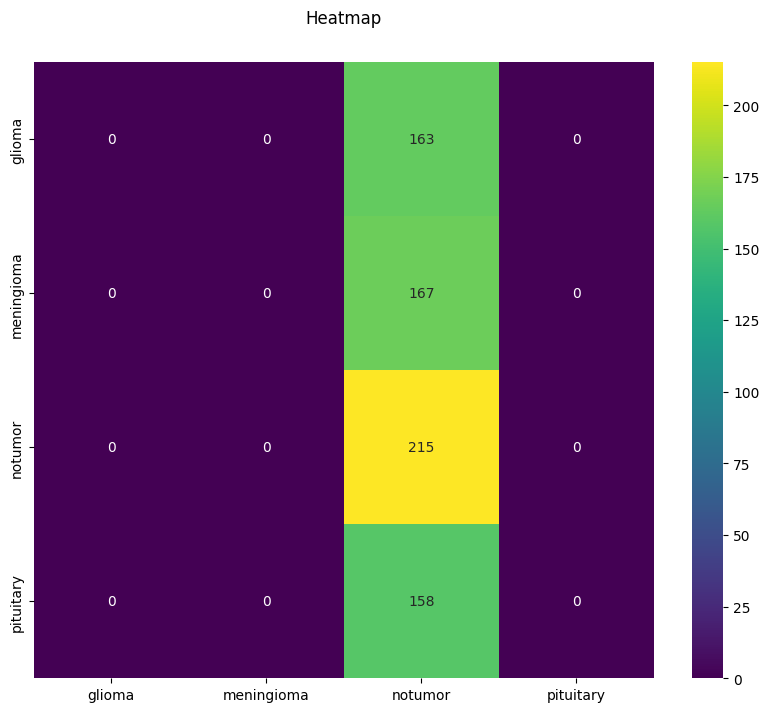

In [67]:
# Function call
Model3(shape, labels, X_train, X_test, y3_train, y3_test, loss = 'categorical_crossentropy')

Function definition

In [68]:
# Pre-trained model
def pre_trained_performance(shape, labels, X_train, X_test, y_train, y_test):
  # Pre-trained model
  efficient_net = EfficientNetB0(input_shape = shape, weights='imagenet',include_top=False)
  # Model definition
  model = efficient_net.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=efficient_net.input, outputs = model)
  # Model summary
  # model.summary()
  # Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])
  # Model fit
  history = model.fit(X_train,y3_train,validation_data = (X_test, y3_test), epochs =12, verbose=1, batch_size=32)
  print('\nModel Evaluation\n')
  History(history)
  print()
  print()
  # Accuracy
  print('\nModel Accuracy and Loss\n')
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {test_acc}')
  print(f'TestLoss: {test_loss}')
  print()
  print()
  # Prediction
  pred = model.predict(X_test)
  pred = np.argmax(pred,axis=1)
  y_test_new = np.argmax(y_test,axis=1)
  # Classification report
  print('\nClassification Report\n')
  report = classification_report(y_test_new, pred)
  print(report)
  print()
  print()
  # Heatmap
  fig, ax = plt.subplots(figsize = (10, 8))
  sns.heatmap(confusion_matrix(y_test_new, pred), xticklabels=labels, yticklabels=labels,annot=True,
            cmap='viridis', fmt = 'g')
  plt.title('Heatmap', y = 1.05);


In [69]:
# Saving the original model and a tflite model
def save_pretrained_model(shape, X_train, X_test, y_train, y_test):
  # Pre-trained model
  efficient_net = EfficientNetB0(input_shape = shape, weights='imagenet',include_top=False)
  # Model definition
  model = efficient_net.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  # Reduce overfitting
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=efficient_net.input, outputs = model)
  # Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])
  # Callbacks
  # Saving the logs
  tensorboard = TensorBoard(log_dir = 'logs')
  #Saving the model
  checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
  # Reduce learning rate once learning stagnates
  reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                                mode='auto',verbose=1)
  # Model fitting
  model.fit(X_train,y3_train,validation_data = (X_test, y3_test), epochs =12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  # Converting the model to a tflite model
  tflite_model = converter.convert()

  # Saving the tflite model
  with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/12
198/198 [==============================] - 1009s 5s/step - loss: 0.2686 - accuracy: 0.9022 - val_loss: 0.2712 - val_accuracy: 0.8962
Epoch 2/12
198/198 [==============================] - 977s 5s/step - loss: 0.1006 - accuracy: 0.9641 - val_loss: 0.2105 - val_accuracy: 0.9232
Epoch 3/12
198/198 [==============================] - 990s 5s/step - loss: 0.0616 - accuracy: 0.9826 - val_loss: 0.0860 - val_accuracy: 0.9659
Epoch 4/12
198/198 [==============================] - 964s 5s/step - loss: 0.0509 - accuracy: 0.9835 - val_loss: 0.0990 - val_accuracy: 0.9687
Epoch 5/12
198/198 [==============================] - 955s 5s/step - loss: 0.0519 - accuracy: 0.9824 - val_loss: 0.0741 - val_accuracy: 0.9844
Epoch 6/12
198/198 [==============================] - 954s 5s/step - loss: 0.0386 - accuracy: 0.9859 - val_loss: 0.0895 - val_accuracy: 0.9758
Epoch 7/12
198/198 [==============================] - 946s 5s/step - loss: 0

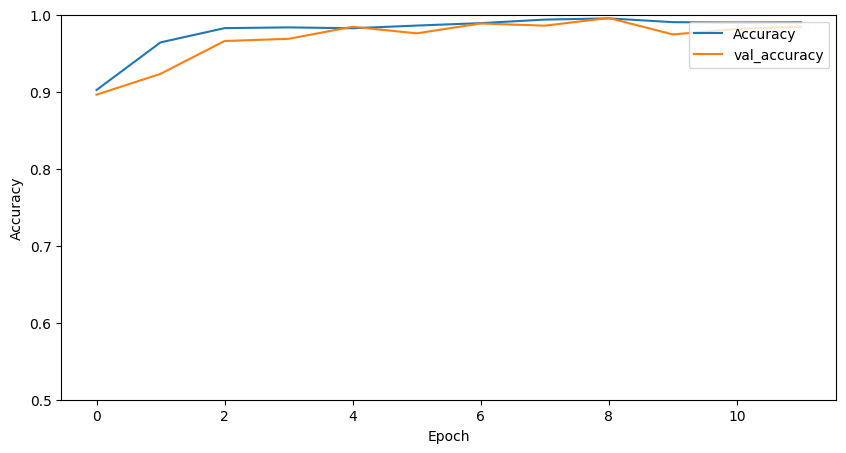




Model Accuracy and Loss

22/22 [==============================] - 23s 1s/step - loss: 0.0293 - accuracy: 0.9844
Test Accuracy: 0.9843527674674988
TestLoss: 0.02927219867706299


22/22 [==============================] - 24s 1s/step

Classification Report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       163
           1       0.99      0.95      0.97       167
           2       0.98      1.00      0.99       215
           3       0.98      0.99      0.99       158

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703





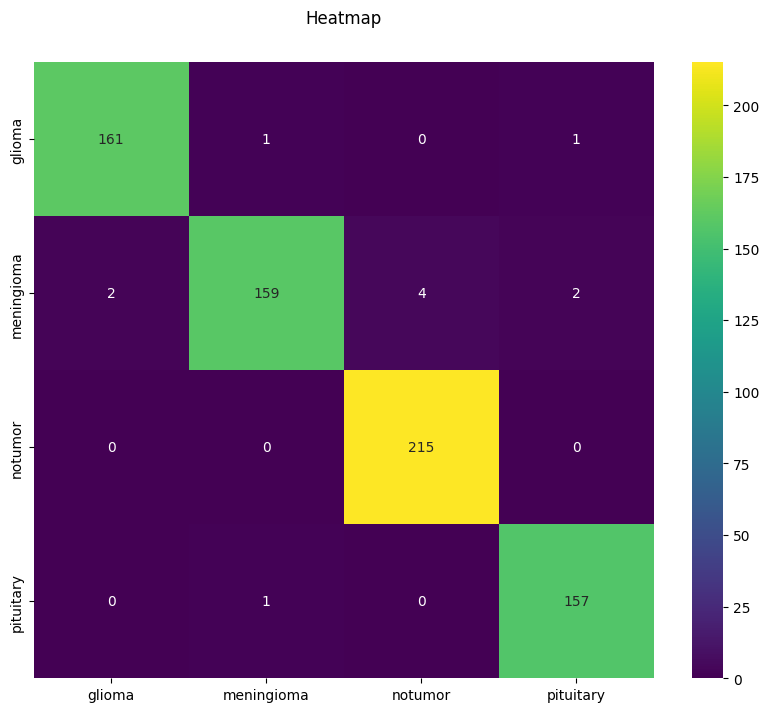

In [70]:
# Employing the pretrained model
pre_trained_performance(shape, labels, X_train, X_test, y3_train, y3_test)

In [ ]:
# Saving the original model, as well as the tflite model
save_pretrained_model(shape, X_train, X_test, y3_train, y3_test)

Epoch 1/12
92/92 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8457
Epoch 1: val_accuracy improved from -inf to 0.86239, saving model to effnet.h5
92/92 [==============================] - 43s 341ms/step - loss: 0.4248 - accuracy: 0.8457 - val_loss: 0.5169 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 2/12
92/92 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9387
Epoch 2: val_accuracy improved from 0.86239 to 0.94190, saving model to effnet.h5
92/92 [==============================] - 30s 323ms/step - loss: 0.1960 - accuracy: 0.9387 - val_loss: 0.2143 - val_accuracy: 0.9419 - lr: 0.0010
Epoch 3/12
92/92 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9578
Epoch 3: val_accuracy did not improve from 0.94190
92/92 [==============================] - 27s 297ms/step - loss: 0.1352 - accuracy: 0.9578 - val_loss: 1.2097 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 4/12
92/92 [==============================] - ETA: 0s - loss: 0.0

INFO:tensorflow:Assets written to: /tmp/tmp_9pbzaok/assets
